In [0]:
import numpy as np
import tensorflow as tf
from sklearn import datasets
from sklearn.model_selection import train_test_split
from IPython import display
import sys

from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
class LSTM(object):
  def __init__(self, input_size, hidden_size, output_size):
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    
    # 入力層
    self.inputs = tf.placeholder(tf.float32, shape=[None, None, self.input_size], name='inputs')
    
    # 入力ゲート
    self.Wi = tf.Variable(tf.zeros([input_size, hidden_size]))
    self.Ui = tf.Variable(tf.zeros([hidden_size, hidden_size]))
    self.bi = tf.Variable(tf.zeros([hidden_size]))
    
    # 忘却ゲート
    self.Wf = tf.Variable(tf.zeros([input_size, hidden_size]))
    self.Uf = tf.Variable(tf.zeros([hidden_size, hidden_size]))
    self.bf = tf.Variable(tf.zeros([hidden_size]))
    
    # 出力ゲート
    self.Wo = tf.Variable(tf.zeros([input_size, hidden_size]))
    self.Uo = tf.Variable(tf.zeros([hidden_size, hidden_size]))
    self.bo = tf.Variable(tf.zeros([hidden_size]))
    
    # セルへの書き込み部分
    self.Wc = tf.Variable(tf.zeros([input_size, hidden_size]))
    self.Uc = tf.Variable(tf.zeros([hidden_size, hidden_size]))
    self.bc = tf.Variable(tf.zeros([hidden_size]))
    
    # 出力層
    self.Wv = tf.Variable(tf.truncated_normal([hidden_size, output_size], mean=0, stddev=0.01))
    self.bv = tf.Variable(tf.truncated_normal([output_size], mean=0, stddev=0.01))
    
    self.init_hidden = tf.matmul(self.inputs[:,0,:], tf.zeros([input_size, hidden_size]))
    self.init_hidden = tf.stack([self.init_hidden, self.init_hidden])
    
    self.input_fn = self._get_batch_input(self.inputs)
    
  def forward(self, prev_state, x):
    h, c = tf.unstack(prev_state)
    
    i = tf.sigmoid(
        tf.matmul(x, self.Wi) + tf.matmul(h, self.Ui) + self.bi)
    
    f = tf.sigmoid(
        tf.matmul(x, self.Wf) + tf.matmul(h, self.Uf) + self.bf)
    
    o = tf.sigmoid(
        tf.matmul(x, self.Wo) + tf.matmul(h, self.Uo) + self.bo)
    
    c_tmp = tf.nn.tanh(
        tf.matmul(x, self.Wc) + tf.matmul(h, self.Uc) + self.bc)
    
    c = f * c + i * c_tmp
    
    h = o * tf.nn.tanh(c)
    
    return tf.stack([h, c])
  
  
  def _get_batch_input(self, inputs):
    return tf.transpose(tf.transpose(inputs, perm=[2, 0, 1]))
    
  def calc_all_layers(self):
    all_hidden_states = tf.scan(self.forward, self.input_fn, initializer=self.init_hidden, name='states')
    return all_hidden_states[:, 0, :, :]
  
  def calc_output(self, state):
    return tf.nn.relu(tf.matmul(state, self.Wv) + self.bv)
  
  def calc_outputs(self):
    all_states = self.calc_all_layers()
    all_outputs = tf.map_fn(self.calc_output, all_states)
    
    return all_outputs

In [0]:
class GRU(object):
  def __init__(self, input_size, hidden_size, output_size):
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    
    # 入力層
    self.inputs = tf.placeholder(tf.float32, shape=[None, None, input_size], name='inputs')
    
    
    self.Wx = tf.Variable(tf.zeros([input_size, hidden_size]))
    self.Wr = tf.Variable(tf.zeros([input_size, hidden_size]))
    self.Wz = tf.Variable(tf.zeros([input_size, hidden_size]))
    
    self.Ux = tf.Variable(tf.zeros([hidden_size, hidden_size]))
    self.Ur = tf.Variable(tf.zeros([hidden_size, hidden_size]))
    self.Uz = tf.Variable(tf.zeros([hidden_size, hidden_size]))
    
    self.br = tf.Variable(tf.truncated_normal([hidden_size], mean=1))
    self.bz = tf.Variable(tf.truncated_normal([hidden_size], mean=1))
        
    self.Wv = tf.Variable(tf.truncated_normal([hidden_size, output_size], mean=0, stddev=0.01))
    self.bv = tf.Variable(tf.truncated_normal([output_size], mean=1, stddev=0.01))

    self.input_fn = self._get_batch_input(self.inputs)
    
    self.init_hidden = self.inputs[:, 0, :]
    self.init_hidden = tf.matmul(
        self.init_hidden, tf.zeros([input_size, hidden_size]))    
    
  def forward(self, prev_h, x):
    
    #z = tf.sigmoid(tf.matmul(x, self.Wz) + tf.matmul(prev_h, self.Uz) + self.bz)
    #r = tf.sigmoid(tf.matmul(x, self.Wr) + tf.matmul(prev_h, self.Ur) + self.br)
    
    z = tf.sigmoid(tf.matmul(x, self.Wz) + tf.matmul(prev_h, self.Uz))
    r = tf.sigmoid(tf.matmul(x, self.Wr) + tf.matmul(prev_h, self.Ur))
    
    h_tmp = tf.tanh(tf.matmul(x, self.Wx) + tf.matmul(prev_h, self.Ux) * r)

    new_h = (1-z) * prev_h + z * h_tmp
    
    return new_h
    
    
  def _get_batch_input(self, inputs):
    return tf.transpose(tf.transpose(inputs, perm=[2, 0, 1]))
    
    
  def calc_all_layers(self):
    all_hidden_states = tf.scan(self.forward, self.input_fn, initializer=self.init_hidden, name='states')
    return all_hidden_states
  
  
  def calc_output(self, state):
    return tf.nn.relu(tf.matmul(state, self.Wv) + self.bv)
  
  
  def calc_outputs(self):
    all_states = self.calc_all_layers()
    all_outputs = tf.map_fn(self.calc_output, all_states)
    
    return all_outputs

In [0]:
def get_on_hot(number):
    on_hot=[0]*10
    on_hot[number]=1
    return on_hot
  
digits = datasets.load_digits()
X=digits.images
Y_=digits.target

Y=map(get_on_hot,Y_)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train=X_train[:1400]
y_train=y_train[:1400]

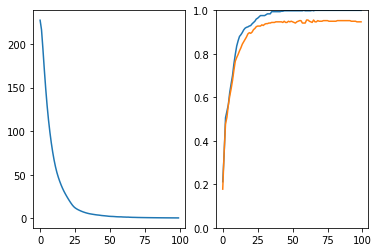

[99] loss: 0.39293745 acc: 1.0 val acc: 0.94722223


In [0]:
from IPython.display import clear_output
  
hidden_size = 50
input_size = 8
output_size = 10

y = tf.placeholder(tf.float32, shape=[None, output_size], name='inputs')

lstm = GRU(input_size, hidden_size, output_size)
outputs = lstm.calc_outputs()

last_output = outputs[-1]

output = tf.nn.softmax(last_output)

# cross entropy loss
loss = -tf.reduce_sum(y * tf.log(output))

train_step = tf.train.AdamOptimizer().minimize(loss)

correct_predictions = tf.equal(tf.argmax(y, 1), tf.argmax(output, 1))
acc = (tf.reduce_mean(tf.cast(correct_predictions, tf.float32)))

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

log_loss = []
log_acc = []
log_val_acc = []

for epoch in range(100):
    
    start=0
    end=100
    for i in range(14):
        
        X=X_train[start:end]
        Y=y_train[start:end]
        
        start=end
        end=start+100
        sess.run(train_step,feed_dict={lstm.inputs:X, y:Y})
    
    log_loss.append(sess.run(loss,feed_dict={lstm.inputs:X, y:Y}))
    log_acc.append(sess.run(acc,feed_dict={lstm.inputs:X_train[:500], y:y_train[:500]}))
    log_val_acc.append(sess.run(acc,feed_dict={lstm.inputs:X_test, y:y_test}))
    
    clear_output(wait=True)
    
    plt.subplot(1, 2, 1)
    plt.plot(range(epoch+1), log_loss)
    
    plt.subplot(1, 2, 2)
    plt.ylim(0., 1.)
    plt.plot(range(epoch+1), log_acc)
    plt.ylim(0., 1.)
    plt.plot(range(epoch+1), log_val_acc)
    
    plt.show()
    
    print("\r[%s] loss: %s acc: %s val acc: %s"%(epoch, log_loss[-1], log_acc[-1], log_val_acc[-1])),